In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
import scipy.optimize as optimize

(160, 160)


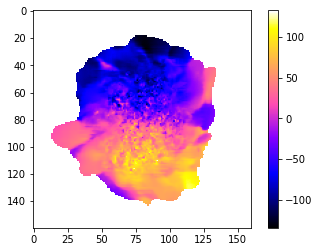

In [2]:
v = np.loadtxt("velmap.txt")
print(v.shape)
plt.imshow(v,cmap="gnuplot2")
plt.colorbar()

[]


(182, 182)


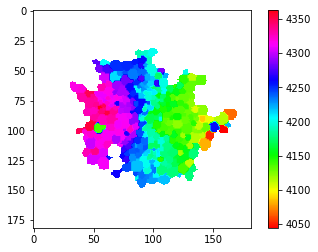

In [3]:

hdu = fits.open("ugc4555_rv_voro.fits")
velmap = hdu[0].data
print(velmap.shape)
plt.imshow(velmap,cmap="hsv",interpolation=None)
plt.colorbar()

In [4]:
def obs_vel_map(xx, r_max, r_t, v_t, incl, Psi_0, v_sys):
    """
    Function to calculate the circular velocity in each radius of the galaxy according 
    to the simplest model of a galaxy's rotation curve (velocity grows linearly at the 
    beginning and then is constant).
    
    Parameters:
    -----------
    y_x : Square matrix
    r_max : Maximum radius of the galaxy (limits)
    r_t : Distance at which the galaxy reaches the maximum speed
    v_t : Maximum speed of the galaxy
    incl :  inclination angle
    Psi_0 : position angle
    v_sys : systemic velocity
    
    Return:
    ----------
    v_los : Matrix of galaxy velocity along the line of sight
    """ 

    yy = xx.transpose()
    npix = yy.shape[0]
    # central position of the array
    xc,yc = npix/2 -0.5, npix/2 -0.5
    # R and Psi matrix
    R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
    Psi = np.arctan((yy-yc)/(xx-xc))
    Psi = np.rad2deg(Psi) + 90
    Psi[int(npix/2):,:] = Psi[int(npix/2):,:]+180
    
    
    # alpha and r matrix            
    alpha = np.sqrt(np.cos((Psi-Psi_0)*np.pi/180)**2 + (np.sin((Psi-Psi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
    r = R*alpha  # Real radius in galaxy in pixels calculated from the projection of them

    #Conversion factor from pixels to radius
    #pix2r = r_max/(npix/(2*np.cos(Psi_0*np.pi/180)))
    #r = r_pix*pix2r  #Distance in the units of the radius
                
    v_cir = -v_t*np.e**(-r/r_t)+v_t  
    #v_cir[r > r_max] = -0.001#'nan'     # If you want that outside the galaxy the matrix has nan values  
          

    v_los = v_sys + (v_cir/alpha)*np.sin(incl*np.pi/180)*np.cos((Psi-Psi_0)*np.pi/180)
    v_los[r > r_max] =  v_sys #'nan'#v_sys #v_los.max()#'nan'
             
    return v_los.ravel()

In [17]:
def obs_vel_map(xx, r_max, r_t, v_t, incl, Psi_0, v_sys):
 
    yy = xx.transpose()
    npix = yy.shape[0]
    # central position of the array
    xc,yc = npix/2 -0.5, npix/2 -0.5
    # R and Psi matrix
    R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
    Psi = np.arctan((yy-yc)/(xx-xc))
    Psi = np.rad2deg(Psi) + 90
    Psi[int(npix/2):,:] = Psi[int(npix/2):,:]+180
    
    
    # alpha and r matrix            
    alpha = np.sqrt(np.cos((Psi-Psi_0)*np.pi/180)**2 + (np.sin((Psi-Psi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
    r = R*alpha  # Real radius in galaxy in pixels calculated from the projection of them

                
    v_cir = -v_t*np.e**(-r/r_t)+v_t  

    v_los = v_sys + (v_cir/alpha)*np.sin(incl*np.pi/180)*np.cos((Psi-Psi_0)*np.pi/180)
    v_los =  v_sys 
    return v_los.ravel()

[ 60.          42.5        300.           0.         280.
  -3.36068806]


ValueError: cannot reshape array of size 1 into shape (160,160)

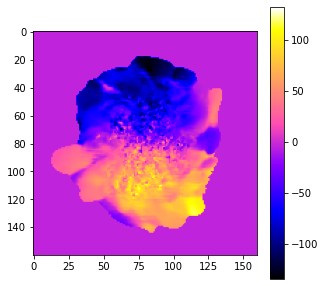

In [18]:
v = np.loadtxt("velmap.txt")
v_max = np.nanmax(v)
v_min = np.nanmin(v)
v[np.isnan(v)]= np.nanmean(v)   #nan values are changed for the mean value of the matrix

x = np.arange(160) #number of rows of data
y = np.arange(160) #number of columns of data
yy,xx = np.meshgrid(x,y)

fig = plt.figure(figsize=(5, 5))
plt.imshow(v,cmap="gnuplot2")
plt.colorbar()

#I try to avoid nan values with check_finite= False, but it didn't work 
popt,pconv = optimize.curve_fit(obs_vel_map, xx, v.ravel(), bounds = ([40, 5, 100, -90, 200, -10], [80, 80, 500, 90, 360, 5]), method = 'trf') 
print(popt) 
obs=obs_vel_map(xx, *popt).reshape(160, 160)
fig = plt.figure(figsize=(5, 5))
plt.imshow(obs,cmap="gnuplot2", vmax = v_max, vmin = v_min )
plt.colorbar()

In [ ]:
## This is the first version of velocity maps
import numpy as np

class Galaxies:

    def __init__(self, vel_map, npix, r_max, r_t, v_t, incl, phi_0, v_sys):
        
        self.Vp = vel_map
        self.npix = npix
        self.r_max = r_max
        self.r_t = r_t
        self.v_t = v_t
        self.incl = incl
        self.phi_0 = phi_0
        self.v_sys = v_sys

        #Fundamental geometricl quatities
        self.r,self.alpha,self.psi = self.Geometry(self.npix, self.phi_0, self.incl)

        # Circular velocity, deprojected from the observed velocity
        self.v_circ = self.velocity(self.v_t)

        # Circular velocity, projected from the observed velocity
        self.v_los = self.project(self.v_circ)

    # Fundamental geometrical quantities. 'r' is in pixels (plane of the galaxy),'alpha','psi' in radians.
    def Geometry(self, npix, phi_0, incl):
        x = np.arange(npix)
        y = np.arange(npix)
        # Array of x,y coordinates, an element for each pixel in the image
        yy,xx = np.meshgrid(x,y)
        # central position of the array
        xc,yc = npix/2 -0.5, npix/2 -0.5
        # R and Psi matrix
        R = np.sqrt((xx-xc)**2 + (yy-yc)**2)
        Psi = np.arctan((yy-yc)/(xx-xc))
        Psi = np.rad2deg(Psi) + 90
        Psi[int(npix/2):,:] = Psi[int(npix/2):,:]+180
        # alpha and r matrix            
        alpha = np.sqrt(np.cos((Psi-phi_0)*np.pi/180)**2 + (np.sin((Psi-phi_0)*np.pi/180)**2)/np.cos(incl*np.pi/180)**2)
        r = R*alpha  # Real rad
        return r,alpha,Psi

    # This modul calculate the circular velocity
    def velocity(self, v_t):
        v_cir = -v_t*np.e**(-self.r/self.r_t)+v_t  
        v_cir[v_cir > -v_t*np.e**(-self.r_max/self.r_t)+v_t ] = 'nan'
        return v_cir

    # Calculates the velocity projected along the line-of-sight.
    def project(self,v_cir):
        v_los = self.v_sys + (v_cir/self.alpha)*np.sin(self.incl*np.pi/180)*np.cos((self.psi-self.phi_0)*np.pi/180)
        return v_los

In [26]:
class robot:
    def __init__(self,name,age):
        self.name = name
        self.age = age
        self.print_variables()
        
    def print_variables(self):
        self.age2 = self.age*2
        
    

In [27]:
r1 = robot('Jorge',21)

In [29]:
r1.age2

42